In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.metrics import f1_score, classification_report
from matplotlib import pyplot as plt

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy

class SugenoDepressionAnalyzer:
    def __init__(self, file_path):
        """Инициализация анализатора с загрузкой данных"""
        self.data = pd.read_csv(file_path)
        self.weights = {}
        self.features = [
            'Academic Pressure',
            'Work Pressure',
            'Sleep Duration',
            'Financial Stress',
            'Family History of Mental Illness',
            'Have you ever had suicidal thoughts ?'
        ]
    def _preprocess_data(self):
        """Нормализация и преобразование данных"""
        # Бинарное кодирование
        self.data['Family History of Mental Illness'] = self.data['Family History of Mental Illness'].map(
            {'Yes': 1, 'No': 0})
        self.data['Have you ever had suicidal thoughts ?'] = self.data['Have you ever had suicidal thoughts ?'].map(
            {'Yes': 1, 'No': 0})
        
        # Преобразование категориальных данных о сне
        sleep_map = {
            'Less than 5 hours': 0.2,
            '5-6 hours': 0.4,
            '6-7 hours': 0.7,
            'More than 7 hours': 0.9
        }
        self.data['Sleep Duration'] = self.data['Sleep Duration'].map(sleep_map)
        
        # Нормализация числовых признаков
        scaler = MinMaxScaler()
        for feature in ['Academic Pressure', 'Work Pressure', 'Financial Stress']:
            self.data[feature] = scaler.fit_transform(self.data[[feature]])

    def _calculate_weights(self):
        """Автоматический расчет весов на основе энтропии"""
        normalized = self.data[self.features].apply(lambda x: x/x.sum(), axis=0)
        k = 1/np.log(len(self.data))
        e_j = normalized.apply(lambda x: -k*(x*np.log(x)).sum())
        d_j = 1 - e_j
        self.weights = {feature: weight for feature, weight in zip(self.features, d_j/d_j.sum())}

    def _sugeno_integral(self, row):
        """Вычисление интеграла Сугено для одной записи"""
        sorted_scores = sorted([(f, row[f]) for f in self.features], key=lambda x: x[1])
        cumulative_weight = 0
        sugeno_values = []
        
        for feature, score in sorted_scores:
            cumulative_weight += self.weights[feature]
            sugeno_values.append(min(score, cumulative_weight))
            
        return max(sugeno_values)

    
    def analyze(self):
        """Основной рабочий процесс"""
        self._preprocess_data()
        self._calculate_weights()
        
        print("Рассчитанные веса критериев:")
        for feature, weight in self.weights.items():
            print(f"{feature}: {weight:.3f}")
        
        self.data['Sugeno_Score'] = self.data.apply(self._sugeno_integral, axis=1)
        self.ranked_data = self.data.sort_values('Sugeno_Score', ascending=False)
        
        self._visualize_results()
        self._statistical_analysis()

    
    def _visualize_results(self):
        """Графическое представление результатов"""
        plt.figure(figsize=(15, 10))
        
        # Распределение оценок
        plt.subplot(2, 2, 1)
        plt.hist(self.data['Sugeno_Score'], bins=20, color='skyblue')
        plt.title('Распределение оценок депрессии')
        
        # Топ-15 студентов
        plt.subplot(2, 2, 2)
        top_15 = self.ranked_data.head(15)
        plt.barh(top_15['id'].astype(str), top_15['Sugeno_Score'], color='indianred')
        plt.title('Топ-15 студентов с высоким риском')
        
        # Матрица корреляций
        plt.subplot(2, 2, 3)
        corr_matrix = self.data[self.features + ['Sugeno_Score']].corr()
        plt.imshow(corr_matrix, cmap='coolwarm')
        plt.colorbar()
        plt.title('Матрица корреляций')
        
        # Влияние факторов
        plt.subplot(2, 2, 4)
        feature_impacts = self.data[self.features].mean() * pd.Series(self.weights)
        feature_impacts.sort_values().plot(kind='barh', color='teal')
        plt.title('Вклад факторов')
        
        plt.tight_layout()
        plt.show()
        
    def _statistical_analysis(self):
        """Анализ статистических показателей"""
        print("\nСтатистика по оценкам:")
        print(self.data['Sugeno_Score'].describe())
        
        if 'Depression' in self.data.columns:
            correlation = self.data[['Sugeno_Score', 'Depression']].corr().iloc[0,1]
            print(f"\nКорреляция с исходными данными: {correlation:.3f}")
            
        high_risk = self.data[self.data['Sugeno_Score'] > 0.7]
        print(f"\nСтудентов с высоким риском: {len(high_risk)}")
        print("Распределение по полу:")
        print(high_risk['Gender'].value_counts())
        
    def get_high_risk_students(self, threshold=0.7):
        """Получение списка студентов группы риска"""
        return self.ranked_data[self.ranked_data['Sugeno_Score'] > threshold][
            ['id', 'Gender', 'Age', 'Sugeno_Score'] + self.features]

C:\Users\79277\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Рассчитанные веса критериев:
Academic Pressure: 0.009
Work Pressure: 0.800
Sleep Duration: 0.062
Financial Stress: 0.026
Family History of Mental Illness: 0.063
Have you ever had suicidal thoughts ?: 0.040


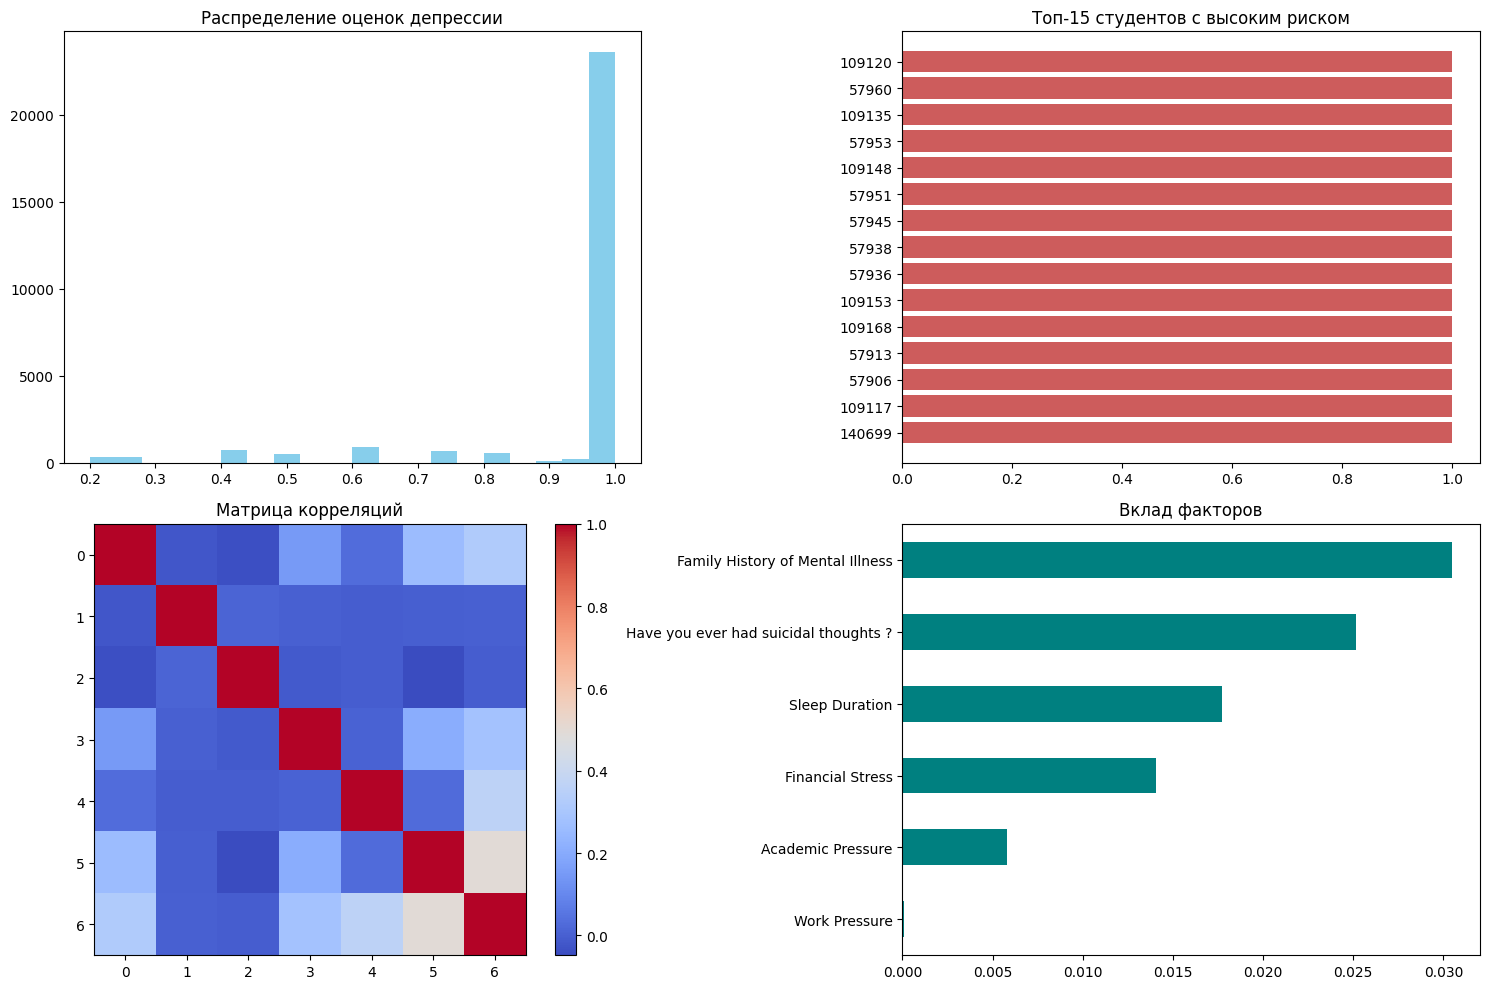


Статистика по оценкам:
count    27901.000000
mean         0.933869
std          0.175736
min          0.200000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Sugeno_Score, dtype: float64

Корреляция с исходными данными: 0.378

Студентов с высоким риском: 25141
Распределение по полу:
Gender
Male      13955
Female    11186
Name: count, dtype: int64

Список студентов с высоким риском:


,id,Gender,Age,Sugeno_Score,Academic Pressure,Work Pressure,Sleep Duration,Financial Stress,Family History of Mental Illness,Have you ever had suicidal thoughts ?
27900,140699,Male,27.0,1.0,0.8,0.0,0.2,0.50,1,1
21608,109117,Male,21.0,1.0,1.0,0.0,NaN,0.25,1,1
11452,57906,Male,22.0,1.0,0.2,0.0,NaN,0.75,1,1
11453,57913,Female,28.0,1.0,0.6,0.0,NaN,0.50,0,1
21618,109168,Male,18.0,1.0,0.6,0.0,0.2,0.50,1,1
21615,109153,Female,24.0,1.0,0.4,0.0,0.2,0.75,1,1
11458,57936,Male,24.0,1.0,0.8,0.0,0.4,1.00,1,1
11459,57938,Male,21.0,1.0,0.4,0.0,NaN,0.25,0,1
11461,57945,Male,32.0,1.0,0.6,0.0,NaN,0.75,1,1
11462,57951,Male,28.0,1.0,0.6,0.0,0.2,0.25,1,1


In [39]:
analyzer = SugenoDepressionAnalyzer('Student Depression Dataset.csv')
analyzer.analyze()

# Получение и вывод студентов группы риска
high_risk = analyzer.get_high_risk_students()
print("\nСписок студентов с высоким риском:")
high_risk.head(10)

In [58]:
df = pd.read_csv('Student Depression Dataset.csv', index_col = 'id')

In [59]:
df

,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,
2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,Yes,0
140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,Yes,0
140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,No,0


In [60]:
# Целевая переменная
target_var = ['Depression']

# Категориальные переменные и их веса
categorical_values = {
    'Sleep Duration': 0.8,
    'Dietary Habits': 0.5
}

# Числовые переменные (чем больше, тем лучше)
numeric_values = {
    'Study Satisfaction': 0.6,
    'Job Satisfaction': 0.7
}

# Числовые переменные (чем меньше, тем лучше)
numeric_values_inv = {
    'Academic Pressure': 0.7,
    'Work Pressure': 0.6,
    'Work/Study Hours': 0.5,
    'Financial Stress': 0.8
}

# Максимальные значения для нормализации
numeric_values_max = df[numeric_values.keys()].max() * 1.2
numeric_values_inv_max = df[numeric_values_inv.keys()].max() * 1.2

# Фаззификация категориальных переменных
sleep_duration_defuzz = {
    'Less than 5 hours': 0.9,
    '5-6 hours': 0.6,
    '7-8 hours': 0.3,
    'More than 8 hours': 0.5,
    'Others': 0.5
}

dietary_habits_defuzz = {
    'Healthy': 0.3,
    'Unhealthy': 0.85,
    'Moderate': 0.5,
    'Others': 0.5
}

categorical_values_defuzz = {
    'Sleep Duration': sleep_duration_defuzz,
    'Dietary Habits': dietary_habits_defuzz
}

# Собираем все независимые переменные
independent_vars = list(categorical_values.keys()) + list(numeric_values.keys()) + list(numeric_values_inv.keys())
independent_vars_weights = {**categorical_values, **numeric_values, **numeric_values_inv}


In [50]:
# Функция для дефаззификации данных
def defuzzify_data(df):
    # Создаем копию DataFrame
    df_defuzz = df.copy()
    
    # 1. Обработка категориальных переменных
    for col in categorical_values_defuzz:
        mapping = categorical_values_defuzz[col]
        df_defuzz[col+'_defuzz'] = df_defuzz[col].map(mapping).fillna(mapping['Others'])
    
    # 2. Обработка числовых переменных (чем больше, тем лучше)
    for col in numeric_values:
        df_defuzz[col+'_defuzz'] = df_defuzz[col] / numeric_values_max[col]
    
    # 3. Обработка числовых переменных (чем меньше, тем лучше)
    for col in numeric_values_inv:
        df_defuzz[col+'_defuzz'] = 1 - (df_defuzz[col] / numeric_values_inv_max[col])
    
    # 4. Применение весов
    for col in independent_vars:
        defuzz_col = col+'_defuzz'
        if defuzz_col in df_defuzz.columns:
            df_defuzz[defuzz_col] *= independent_vars_weights[col]
    
    # 5. Расчет интегрального показателя
    defuzz_cols = [col+'_defuzz' for col in independent_vars]
    df_defuzz['Depression_Risk_Score'] = df_defuzz[defuzz_cols].mean(axis=1)
    
    return df_defuzz

# Применяем дефаззификацию
df_defuzzified = defuzzify_data(df)

# Выводим результаты
print("Дефаззифицированные данные:")
df_defuzzified[[col for col in df_defuzzified.columns if '_defuzz' in col or col == 'Depression']]

Дефаззифицированные данные:


,Depression,Sleep Duration_defuzz,Dietary Habits_defuzz,Study Satisfaction_defuzz,Job Satisfaction_defuzz,Academic Pressure_defuzz,Work Pressure_defuzz,Work/Study Hours_defuzz,Financial Stress_defuzz
id,,,,,,,,,
2,1,0.48,0.150,0.2,0.0,0.116667,0.6,0.395833,0.666667
8,0,0.48,0.250,0.5,0.0,0.466667,0.6,0.395833,0.533333
26,0,0.72,0.150,0.5,0.0,0.350000,0.6,0.187500,0.666667
30,1,0.24,0.250,0.2,0.0,0.350000,0.6,0.361111,0.133333
32,0,0.48,0.250,0.3,0.0,0.233333,0.6,0.465278,0.666667
...,...,...,...,...,...,...,...,...,...
140685,0,0.48,0.425,0.5,0.0,0.116667,0.6,0.256944,0.666667
140686,0,0.72,0.150,0.3,0.0,0.466667,0.6,0.500000,0.400000
140689,0,0.48,0.425,0.4,0.0,0.350000,0.6,0.083333,0.533333


In [61]:
def sugeno_integral(values, weights):
    """
    Вычисляет интеграл Сугено для заданных значений и весов.

    Параметры:
    - values: список значений функции (f(x1), f(x2), ..., f(xn))
    - weights: список мер (g({x1}), g({x2}), ..., g({xn})), определяющих важность.

    Возвращает:
    - Значение интеграла Сугено.
    """
    if len(values) != len(weights):
        raise ValueError("values и weights должны быть одинаковой длины")

    # Сортируем по значениям по убыванию
    paired = sorted(zip(values, weights), key=lambda x: -x[0])
    sorted_values, _ = zip(*paired)

    max_min = 0

    # На каждой итерации считаем меру множества из i-го до последнего
    for i in range(len(paired)):
        # Выделяем индексы с текущего до конца
        subset_weights = [w for _, w in paired[i:]]
        # Мера множества — максимум из весов (если мера аддитивна — можно использовать сумму)
        subset_measure = max(subset_weights)  # или другой способ задания меры g
        current_min = min(sorted_values[i], subset_measure)
        max_min = max(max_min, current_min)

    return max_min

In [62]:
df = df[
    independent_vars + target_var
    ]
df.loc[:, numeric_values.keys()] = df[numeric_values.keys()] / numeric_values_max
df.loc[:, numeric_values_inv.keys()] = 1 - df[numeric_values_inv.keys()] / numeric_values_inv_max

for col, mapping in categorical_values_defuzz.items():
    df.loc[:, col] = df[col].map(mapping)

df

,Sleep Duration,Dietary Habits,Study Satisfaction,Job Satisfaction,Academic Pressure,Work Pressure,Work/Study Hours,Financial Stress,Depression
id,,,,,,,,,
2,0.6,0.3,0.333333,0.0,0.166667,1.0,0.791667,0.833333,1
8,0.6,0.5,0.833333,0.0,0.666667,1.0,0.791667,0.666667,0
26,0.9,0.3,0.833333,0.0,0.500000,1.0,0.375000,0.833333,0
30,0.3,0.5,0.333333,0.0,0.500000,1.0,0.722222,0.166667,1
32,0.6,0.5,0.500000,0.0,0.333333,1.0,0.930556,0.833333,0
...,...,...,...,...,...,...,...,...,...
140685,0.6,0.85,0.833333,0.0,0.166667,1.0,0.513889,0.833333,0
140686,0.9,0.3,0.500000,0.0,0.666667,1.0,1.000000,0.500000,0
140689,0.6,0.85,0.666667,0.0,0.500000,1.0,0.166667,0.666667,0


In [63]:
integral_values = list()
cols, weights = zip(*independent_vars_weights.items())
df_sugeno = df.loc[:, list(cols)]
df['SugenoIntegral'] = df_sugeno.apply(lambda row: sugeno_integral(row, weights), axis=1)
df

C:\Users\79277\AppData\Local\Temp\ipykernel_14220\745399684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SugenoIntegral'] = df_sugeno.apply(lambda row: sugeno_integral(row, weights), axis=1)


,Sleep Duration,Dietary Habits,Study Satisfaction,Job Satisfaction,Academic Pressure,Work Pressure,Work/Study Hours,Financial Stress,Depression,SugenoIntegral
id,,,,,,,,,,
2,0.6,0.3,0.333333,0.0,0.166667,1.0,0.791667,0.833333,1,0.8
8,0.6,0.5,0.833333,0.0,0.666667,1.0,0.791667,0.666667,0,0.8
26,0.9,0.3,0.833333,0.0,0.500000,1.0,0.375000,0.833333,0,0.8
30,0.3,0.5,0.333333,0.0,0.500000,1.0,0.722222,0.166667,1,0.8
32,0.6,0.5,0.500000,0.0,0.333333,1.0,0.930556,0.833333,0,0.8
...,...,...,...,...,...,...,...,...,...,...
140685,0.6,0.85,0.833333,0.0,0.166667,1.0,0.513889,0.833333,0,0.8
140686,0.9,0.3,0.500000,0.0,0.666667,1.0,1.000000,0.500000,0,0.8
140689,0.6,0.85,0.666667,0.0,0.500000,1.0,0.166667,0.666667,0,0.8


In [64]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Depression', axis=1), df['Depression'], test_size=0.3, random_state=42)

In [65]:
def calculat_f1(threshold):
    preds = (X_train['SugenoIntegral'] < threshold[0]).astype(np.int32)
    return -f1_score(y_train, preds)

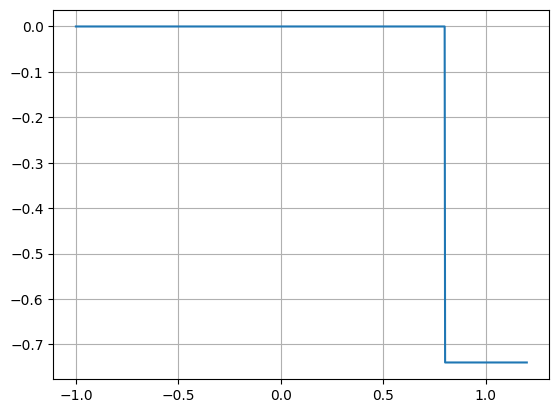

In [68]:
length = 1000

thresh_values = np.linspace(-1, 1.2, length)[..., None]
f1_values = np.zeros(length)

for idx, thresh in enumerate(thresh_values):
    f1_values[idx] = calculat_f1(thresh)

plt.plot(thresh_values, f1_values)
plt.grid(True)